# 从0开始实现

首先实现`dropout_layer`函数，该函数以`dropout`的概率丢弃张量输入`X`中的元素

In [1]:
import torch
from torch import nn
import d2l_torch as d2l

In [7]:
torch.Tensor(2,5).uniform_(0,1)>0.3

tensor([[False,  True, False, False, False],
        [False,  True,  True,  True,  True]])

常规来说，>0.3的概率应该就是0.7，所以应该是3个false，7个true，不过有一定的随机误差，可以接收。

In [9]:
torch.rand(2,5)>0.3

tensor([[ True, False, False,  True, False],
        [ True, False,  True,  True,  True]])

In [11]:
def dropout_layer(X,dropout):
    assert 0<=dropout<=1
    if dropout==1:
        # 全部丢弃
        return torch.zeros_like(X)
    if dropout==0:
        # 一个都不丢
        return X
#     mask=(torch.Tensor(X.shape).uniform_(0,1)>dropout).float()
    mask=(torch.rand(X.shape)>dropout).float()
    # 以随机概率生成一个mask矩阵，过滤掉失活的神经元的输出
    return mask*X/(1.0-dropout)

+ 不写成numpy里的那种`X[mask]`的形式，是因为这种形式对cpu和gpu都不友好
+ 对于GPU来说，乘法运算，远远比这种选择要快

测试一下`dropout_layer`函数

In [17]:
X=torch.arange(16,dtype=torch.float32).reshape((2,8))
print(X)
print(f"dropout=0.0,返回的X为 \n {dropout_layer(X,0.)}")
print(f"dropout=0.5,返回的X为\n {dropout_layer(X,0.5)}")
print(f"dropout=0.9,返回的X为\n {dropout_layer(X,0.9)}")
# print(f"dropout=1,返回的X为\n {dropout_layer(X,1.)}")

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout=0.0,返回的X为 
 tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout=0.5,返回的X为
 tensor([[ 0.,  2.,  4.,  6.,  8., 10.,  0.,  0.],
        [16.,  0.,  0., 22.,  0.,  0., 28.,  0.]])
dropout=0.9,返回的X为
 tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,  70.],
        [  0.,   0., 100.,   0.,   0.,   0.,   0.,   0.]])


从上面可以看出，
+ 例如，当`dropout=0.5`的时候，虽然有部分值变成了0，但是剩下那些有值的因为除以(1-p),相当于扩大2倍，
+ 所以整体来说，使用了dropout之后的输出和之前的输出的期望（均值）是一样的。

定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元。

还是使用之前的FASHION MINIST数据集

In [20]:
num_inputs,num_outputs,num_hiddens1,num_hiddens2=784,10,256,256

dropout1,dropout2=0.2,0.5

class Net(nn.Module):
    def __init__(self,num_inputs,num_outputs,num_hiddens1,num_hiddens2,dropout1,dropout2,is_training=True):
        super(Net,self).__init__()
        # 不是所有变量都要定义成 成员变量的
        self.num_inputs=num_inputs
        self.training=is_training
        self.lin1=nn.Linear(num_inputs,num_hiddens1)
        # 只规定输入和输出的size
        self.lin2=nn.Linear(num_hiddens1,num_hiddens2)
        self.lin3=nn.Linear(num_hiddens2,num_outputs)
        self.relu=nn.ReLU()
    
    def forward(self,X):
        H1=self.relu(self.lin1(X.reshape(-1,self.num_inputs)))
        # 真正使用的时候 只传入输入的size，输出是之前定好的，是这个函数要满足的
        if self.training==True:
            H1=dropout_layer(H1,dropout1)
            
        H2=self.relu(self.lin2(H1))
        if self.training==True:
            H2=dropout_layer(H2,dropout2)   
        out=self.lin3(H2)
        return out

net=Net(num_inputs,num_outputs,num_hiddens1,num_hiddens2,dropout1,dropout2)

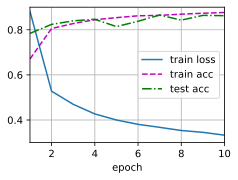

In [19]:
num_epochs,lr,batch_size=10,0.5,256
loss=nn.CrossEntropyLoss()

train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)

trainer=torch.optim.SGD(net.parameters(),lr=lr)

d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

+ 之前跑这个数据集的时候，用的是一个只有一个隐藏层的MLP
+ 这里用了两个隐藏层，而且每层256个单元，已经是一个很大的神经网络了
+ 所以其实dropout在这里发挥了很大的放置过拟合的功能

AssertionError: 2.3069020617167153

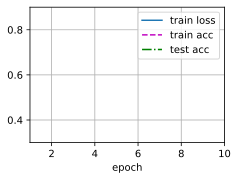

In [24]:
net2=Net(num_inputs,num_outputs,num_hiddens1,num_hiddens2,0,0)
d2l.train_ch3(net2,train_iter,test_iter,loss,num_epochs,trainer)

可以看一下，如果不使用dropout，可以看到，没有发生明显的过拟合现象

# 简洁实现

In [26]:
net=nn.Sequential(nn.Flatten(),nn.Linear(784,256),nn.ReLU(),
                 nn.Dropout(dropout1),nn.Linear(256,256),nn.ReLU(),
                 nn.Dropout(dropout2),nn.Linear(256,10))
def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight,std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

AssertionError: 2.3029855775197348

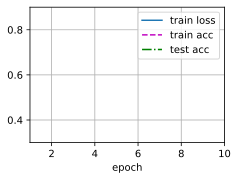

In [27]:
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

比较不幸的是，我总是会在train_ch3这里发生断言错误。

# 扩展

## randn和rand函数

In [10]:
torch.randn(10,10)

tensor([[-0.6582, -0.4559,  0.7287, -0.0523,  1.5146, -0.7228,  0.0971,  0.2716,
          0.3451, -0.2326],
        [-0.3846, -0.6259,  1.0942,  0.6398,  0.7083,  1.0366, -1.0150, -0.0212,
         -0.8492,  0.5577],
        [ 0.7285,  0.8641, -0.2814, -0.5586,  1.4437, -1.0472,  0.7180,  0.2124,
         -0.6180,  0.4962],
        [ 0.0235, -0.1757, -0.1846, -1.0358, -0.0932, -0.5437,  0.5705, -1.6582,
          0.8237, -0.2467],
        [ 0.1103, -1.8840, -1.8970, -0.9078, -1.1507,  0.3638,  0.1704, -1.0693,
         -1.5487, -0.5539],
        [ 1.0781,  0.2837,  0.0430, -1.1463, -1.1000,  0.4587, -0.2825, -0.9339,
          0.2651,  1.3806],
        [-2.2889,  0.7980, -1.1566,  0.4657,  0.0191,  0.7051, -0.5392, -1.8916,
         -0.8123, -0.5425],
        [-0.3818,  0.5590,  0.9074, -1.5561,  0.4708,  1.7021,  1.6138, -0.0595,
          0.6954, -0.9979],
        [-0.5196, -0.2622, -2.0723,  0.3792,  0.1171, -0.7064,  0.1164,  0.6830,
         -0.9522,  0.2671],
        [ 0.1908,  

+ randn是mean=0，std=1的标准正态分布，生成的值范围不一定是[0,1)之间；
+ rand是[0,1)之间的均匀分布，a uniform distribution

![image.png](https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fupload-images.jianshu.io%2Fupload_images%2F10819934-4d9965b55a897b52.png%3FimageMogr2%2Fauto-orient%2Fstrip%257CimageView2%2F2%2Fw%2F1240&refer=http%3A%2F%2Fupload-images.jianshu.io&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1638083534&t=d430bdba82c1c179f2d42b38a5c651b2)

上面只是示意图，y轴范围和实际数据相关
+ 密度函数关于平均值对称
+ 平均值与它的众数（statistical mode）以及中位数（median）同一数值。

![image](https://tse1-mm.cn.bing.net/th/id/R-C.2f3d8874cc1e2f549b7e6c88720d8a38?rik=ZL%2fjQg%2bs8%2fvV8A&riu=http%3a%2f%2fdev1.ed-projects.nyu.edu%2fstatistics%2fwp-content%2fuploads%2f2014%2f05%2fnormal1.jpg&ehk=Xx6LNrU1Ex9QOaQi1PBoLgWSCx%2bAoki8SJ5gmJfstgM%3d&risl=&pid=ImgRaw&r=0)